In [ ]:
import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt


import sklearn
import scipy.sparse as sparse
from sklearn import mixture
import itertools
from scipy import linalg
import matplotlib as mpl


import zipfile
zip_ref = zipfile.ZipFile('train.csv.zip', 'r')
zip_ref.extractall('../Fraud Detection/adtracking-fraud-detection-master/')
zip_ref.close()

In [ ]:
data_set=pd.read_csv('../Fraud Detection/train_sample.csv')

In [ ]:
data_set.head()

In [ ]:
data_set.info()

In [ ]:
#Counting how many class 1 
data_set.attributed_time.count()

In [ ]:
data_set.count()

In [ ]:
print(data_set.nunique(),'\n\n')
unique_val=data_set.iloc[:,[1,2,3,4,6,7]].nunique()
print(list(unique_val.keys()))
print(list(unique_val.values))

In [ ]:
len(data_set)-data_set.click_time.nunique()

In [ ]:

xtick_label=list(unique_val.keys())
sns.set(font_scale=2)
fig=plt.figure(figsize=(15,10))
ax = sns.barplot(x=xtick_label,y=list(unique_val.values))
plt.title('The number of unique values of features')

In [ ]:
data_set.app.unique()

In [ ]:
sns.set(font_scale=1.2)
fig, axes = plt.subplots(2,2,figsize=(15,8))
sns.distplot(data_set.app,label='App',kde=False,ax=axes[0, 0],color='r')
axes[0, 0].set_title('Histogram of Apps')

sns.distplot(data_set.device,label='Device',kde=False,ax=axes[0, 1],color='b')
axes[0, 1].set_title('Histogram of devices')

sns.distplot(data_set.os,label='OS',kde=False,ax=axes[1, 0],color='g')
axes[1, 0].set_title('Histogram of OS\'s')

sns.distplot(data_set.channel,label='Channel',kde=False,ax=axes[1, 1],color='y')
axes[1, 1].set_title('Histogram of channels')


plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.45,
                    wspace=0.25)

In [ ]:
#data_set.device.value_counts().sort_values()

In [ ]:
#data_set.app.value_counts().sort_values()

In [ ]:
#data_set.os.value_counts().sort_values()

## Converting click_time to datetime type

In [ ]:

from datetime import datetime,timedelta
data_set.attributed_time=pd.to_datetime(data_set.attributed_time)
data_set.click_time=pd.to_datetime(data_set.click_time)
data_set['time_difference']=data_set.attributed_time-data_set.click_time

In [ ]:
data_set['hour_click']= data_set.click_time.map(lambda x: round((x-data_set.click_time.min())/timedelta(hours=1),4))
data_set['click_day']= data_set.click_time.map(lambda x: x.day)
data_set['click_hour']= data_set.click_time.map(lambda x: x.hour)
data_set['click_min']= data_set.click_time.map(lambda x: x.minute)
data_set['click_sec']= data_set.click_time.map(lambda x: x.second)

data_set['hour_attributed']= data_set.attributed_time.map(lambda x: round((x-data_set.attributed_time.min())/timedelta(hours=1),4))
data_set['hour_difference']= data_set.time_difference.map(lambda x: round(x/timedelta(hours=1),4))


In [ ]:
data_set.head()

## Missing Values

In [ ]:
data_set.keys()



In [ ]:
data_set.loc[:,['time_difference','click_time', 'attributed_time']]=data_set.loc[:,['time_difference','click_time', 'attributed_time']].replace(np.nan,pd.to_datetime(0))


In [ ]:
data_set=data_set.replace(np.nan,-1)
data_set.head()


## Extracting More Features

In [ ]:
def counting_features(d,name,f):
    d=d.join(pd.DataFrame({name:d.set_index(f).groupby(f).size()}),on=f)
    return d

In [ ]:
#feature:ip
data_set=counting_features(data_set,'ip_count',['ip'])
data_set=counting_features(data_set,'ip_app_count',['ip','app'])
data_set=counting_features(data_set,'ip_device_count',['ip','device'])
data_set=counting_features(data_set,'ip_channel_count',['ip','channel'])
data_set=counting_features(data_set,'ip_os_count',['ip','os'])
#feature: device
data_set=counting_features(data_set,'device_count',['device'])
data_set=counting_features(data_set,'device_app_count',['device','app'])
data_set=counting_features(data_set,'device_channel_count',['device','channel'])
data_set=counting_features(data_set,'device_os_count',['device','os'])
#feature: os
data_set=counting_features(data_set,'os_count',['os'])
data_set=counting_features(data_set,'os_app_count',['app','os'])
data_set=counting_features(data_set,'os_channel_count',['os','channel'])
#feature: Channel
data_set=counting_features(data_set,'channel_count',['channel'])
data_set=counting_features(data_set,'channel_app_count',['app','channel'])
#feature: click_time
data_set=counting_features(data_set,'click_time_count',['click_time'])
data_set=counting_features(data_set,'ct_ip_count',['click_time','ip'])
data_set=counting_features(data_set,'ct_app_count',['click_time','app'])
data_set=counting_features(data_set,'ct_device_count',['click_time','device'])
data_set=counting_features(data_set,'ct_os_count',['click_time','os'])
data_set=counting_features(data_set,'ct_channel_count',['click_time','channel'])

#feature: time_difference
data_set=counting_features(data_set,'dt_count',['hour_difference'])
data_set=counting_features(data_set,'dt_ip_count',['hour_difference','ip'])
data_set=counting_features(data_set,'dt_app_count',['hour_difference','app'])
data_set=counting_features(data_set,'dt_device_count',['hour_difference','device'])
data_set=counting_features(data_set,'dt_os_count',['hour_difference','os'])
data_set=counting_features(data_set,'dt_channel_count',['hour_difference','channel'])

data_set.head()

# Clustering clicks

In [ ]:
X_cluster=data_set.loc[:,['ip_count', 'ip_app_count', 'ip_device_count',
       'ip_channel_count', 'ip_os_count', 'device_count', 'device_app_count',
       'device_channel_count', 'device_os_count', 'os_count', 'os_app_count',
       'os_channel_count', 'channel_count', 'channel_app_count',
       'click_time_count', 'ct_ip_count', 'ct_app_count', 'ct_device_count',
       'ct_os_count', 'ct_channel_count','hour_click','is_attributed']]

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_cluster=scaler.fit_transform(X_cluster)

In [ ]:
### GMM Clustering
#To find the best component for GMM culstering can be assessed out by a code silimar to doing detemining hyper parameters. This code is from [Gaussian Mixture Model Selection](http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py) website. Based on the comparision given in [Clustering](http://scikit-learn.org/stable/modules/clustering.html), GMM method has chosen for having less expences. [GMM method](http://scikit-learn.org/stable/modules/mixture.html#mixture) is the general form of Kmean. 




print(__doc__)


# Generate random sample, two components

lowest_bic = np.infty
bic = []
n_components_range = range(1, 10)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X_cluster)
        bic.append(gmm.bic(X_cluster))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

In [ ]:
fraud_class=pd.DataFrame({'fraud_class':clf.predict(X_cluster)})
np.sort(fraud_class.loc[:,'fraud_class'].unique())

In [ ]:

data_set['fraud_class']=fraud_class
data_set.head(2)

In [ ]:
data_set.groupby('fraud_class').count()

In [ ]:
sns.distplot(data_set.device,color='seagreen')

In [ ]:
[str(x) for x in np.sort(fraud_class.loc[:,'fraud_class'].unique())]

In [ ]:
sns.set(font_scale=1.5)
fig,axes=plt.subplots(3,2,figsize=(15,10))
sns.distplot(data_set.ip[data_set.fraud_class==0],color='skyblue',hist=False,ax=axes[0, 0])
sns.distplot(data_set.ip[data_set.fraud_class==1],color='olive',hist=False,ax=axes[0, 0])
sns.distplot(data_set.ip[data_set.fraud_class==2],color='gold',hist=False,ax=axes[0, 0])
sns.distplot(data_set.ip[data_set.fraud_class==3],color='teal',hist=False,ax=axes[0, 0])
sns.distplot(data_set.ip[data_set.fraud_class==4],color='coral',hist=False,ax=axes[0, 0])
sns.distplot(data_set.ip[data_set.fraud_class==5],color='tomato',hist=False,ax=axes[0, 0])
sns.distplot(data_set.ip[data_set.fraud_class==6],color='seagreen',hist=False,ax=axes[0, 0])
sns.distplot(data_set.ip[data_set.fraud_class==7],color='darkcyan',hist=False,ax=axes[0, 0])
sns.distplot(data_set.ip[data_set.fraud_class==8],color='maroon',hist=False,ax=axes[0, 0])
axes[0,0].set_title('The distribution of IPs in different classes')

sns.distplot(data_set.app[data_set.fraud_class==0],color='skyblue',hist=False,ax=axes[0, 1])
sns.distplot(data_set.app[data_set.fraud_class==1],color='olive',hist=False,ax=axes[0, 1])
sns.distplot(data_set.app[data_set.fraud_class==2],color='gold',hist=False,ax=axes[0, 1])
sns.distplot(data_set.app[data_set.fraud_class==3],color='teal',hist=False,ax=axes[0, 1])
sns.distplot(data_set.app[data_set.fraud_class==4],color='coral',hist=False,ax=axes[0, 1])
sns.distplot(data_set.app[data_set.fraud_class==5],color='tomato',hist=False,ax=axes[0, 1])
sns.distplot(data_set.app[data_set.fraud_class==6],color='seagreen',hist=False,ax=axes[0, 1])
sns.distplot(data_set.app[data_set.fraud_class==7],color='darkcyan',hist=False,ax=axes[0, 1])
sns.distplot(data_set.app[data_set.fraud_class==8],color='maroon',hist=False,ax=axes[0, 1])
axes[0,1].set_title('The distribution of APPs in different classes')


sns.distplot(data_set.device[data_set.fraud_class==0],color='skyblue',hist=False,ax=axes[1,0])
sns.distplot(data_set.device[data_set.fraud_class==1],color='olive',hist=False,ax=axes[1,0])
sns.distplot(data_set.device[data_set.fraud_class==2],color='gold',hist=False,ax=axes[1,0])
sns.distplot(data_set.device[data_set.fraud_class==3],color='teal',hist=False,ax=axes[1,0])
sns.distplot(data_set.device[data_set.fraud_class==4],color='coral',hist=False,ax=axes[1,0])
sns.distplot(data_set.device[data_set.fraud_class==5],color='tomato',hist=False,ax=axes[1,0])
sns.distplot(data_set.device[data_set.fraud_class==6],color='seagreen',hist=False,ax=axes[1,0])
sns.distplot(data_set.device[data_set.fraud_class==7],color='darkcyan',hist=False,ax=axes[1,0])
sns.distplot(data_set.device[data_set.fraud_class==8],color='maroon',hist=False,ax=axes[1,0])
axes[1,0].set_title('The distribution of devices in different classes')


sns.distplot(data_set.os[data_set.fraud_class==0],color='skyblue',hist=False,ax=axes[1,1])
sns.distplot(data_set.os[data_set.fraud_class==1],color='olive',hist=False,ax=axes[1,1])
sns.distplot(data_set.os[data_set.fraud_class==2],color='gold',hist=False,ax=axes[1,1])
sns.distplot(data_set.os[data_set.fraud_class==3],color='teal',hist=False,ax=axes[1,1])
sns.distplot(data_set.os[data_set.fraud_class==4],color='coral',hist=False,ax=axes[1,1])
sns.distplot(data_set.os[data_set.fraud_class==5],color='tomato',hist=False,ax=axes[1,1])
sns.distplot(data_set.os[data_set.fraud_class==6],color='seagreen',hist=False,ax=axes[1,1])
sns.distplot(data_set.os[data_set.fraud_class==7],color='darkcyan',hist=False,ax=axes[1,1])
sns.distplot(data_set.os[data_set.fraud_class==8],color='maroon',hist=False,ax=axes[1,1])
axes[1,1].set_title('The distribution of OS\' in different classes')

sns.distplot(data_set.hour_click[data_set.fraud_class==0],color='skyblue',hist=False,ax=axes[2, 0])
sns.distplot(data_set.hour_click[data_set.fraud_class==1],color='olive',hist=False,ax=axes[2, 0])
sns.distplot(data_set.hour_click[data_set.fraud_class==2],color='gold',hist=False,ax=axes[2, 0])
sns.distplot(data_set.hour_click[data_set.fraud_class==3],color='teal',hist=False,ax=axes[2, 0])
sns.distplot(data_set.hour_click[data_set.fraud_class==4],color='coral',hist=False,ax=axes[2, 0])
sns.distplot(data_set.hour_click[data_set.fraud_class==5],color='tomato',hist=False,ax=axes[2, 0])
sns.distplot(data_set.hour_click[data_set.fraud_class==6],color='seagreen',hist=False,ax=axes[2, 0])
sns.distplot(data_set.hour_click[data_set.fraud_class==7],color='darkcyan',hist=False,ax=axes[2, 0])
sns.distplot(data_set.hour_click[data_set.fraud_class==8],color='maroon',hist=False,ax=axes[2, 0])
axes[2,0].set_title('The distribution of time difference in hour in different classes')
axes[2,0].set_xlabel('Hour')


plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.45,
                    wspace=0.25)

## Defining dependent and independent features

In [ ]:
data_set.keys()

In [98]:
categorical_features=['ip', 'app', 'device', 'os', 'channel','fraud_class']
temporal_features=['click_time', 'attributed_time', 'time_difference']
numerical_features= ['hour_click','hour_attributed',
       'hour_difference', 'ip_count', 'ip_app_count', 'ip_device_count',
       'ip_channel_count', 'ip_os_count', 'device_count', 'device_app_count',
       'device_channel_count', 'device_os_count', 'os_count', 'os_app_count',
       'os_channel_count', 'channel_count', 'channel_app_count',
       'click_time_count', 'ct_ip_count', 'ct_app_count', 'ct_device_count',
       'ct_os_count', 'ct_channel_count',
       'dt_ip_count', 'dt_app_count', 'dt_device_count', 'dt_os_count',
       'dt_channel_count']


In [99]:
X=data_set.loc[:,numerical_features]
y=data_set.is_attributed
X.head()


,hour_click,hour_attributed,hour_difference,ip_count,ip_app_count,ip_device_count,ip_channel_count,ip_os_count,device_count,device_app_count,...,ct_ip_count,ct_app_count,ct_device_count,ct_os_count,ct_channel_count,dt_ip_count,dt_app_count,dt_device_count,dt_os_count,dt_channel_count
0,17.5106,-1.0,-1.0,8,3,8,1,3,94338,12447,...,1,1,1,1,1,8,13197,94192,21198,238
1,21.6742,-1.0,-1.0,149,4,141,7,8,94338,753,...,1,1,1,1,1,149,804,94192,5226,3130
2,26.0900,-1.0,-1.0,2,1,2,1,2,94338,12447,...,1,1,2,1,1,2,13197,94192,23829,635
3,12.9689,-1.0,-1.0,3,1,3,1,1,94338,2355,...,1,1,2,1,1,3,2422,94192,21198,3960
4,65.0025,-1.0,-1.0,4,2,4,1,1,94338,12447,...,1,1,1,1,1,4,13197,94192,1184,2936


## Splitting data into validation and training sets

In [100]:
from sklearn.model_selection import train_test_split

X_train,X_validation,y_train,y_validation=train_test_split(X,y,test_size=0.15, random_state=42)

In [101]:
print(np.size(X_train),np.size(X_validation))

2380000 420000


In [102]:
X_train.head()

,hour_click,hour_attributed,hour_difference,ip_count,ip_app_count,ip_device_count,ip_channel_count,ip_os_count,device_count,device_app_count,...,ct_ip_count,ct_app_count,ct_device_count,ct_os_count,ct_channel_count,dt_ip_count,dt_app_count,dt_device_count,dt_os_count,dt_channel_count
71584,12.5928,-1.0,-1.0,6,1,6,1,1,94338,8348,...,1,2,3,2,1,6,8984,94192,1348,1074
98962,42.4344,-1.0,-1.0,3,1,3,1,1,94338,12447,...,1,1,1,1,1,3,13197,94192,4826,3130
74509,58.3939,-1.0,-1.0,3,1,3,1,1,94338,17656,...,1,1,1,1,1,3,18275,94192,1310,8112
86798,19.4608,-1.0,-1.0,669,35,577,8,11,94338,5263,...,1,1,1,1,1,666,5359,94192,786,1468
54930,16.4792,-1.0,-1.0,2,1,2,1,2,94338,1256,...,1,1,2,1,1,2,1303,94192,21198,1921


In [103]:
type(X_train)

pandas.core.frame.DataFrame

## Dealing with categorical data

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X = LabelEncoder()
X_train.iloc[:, 19] = labelencoder_X.fit_transform(X_train.iloc[:,19])
onehotencoder = OneHotEncoder(categorical_features = [19])
X_train = onehotencoder.fit_transform(X_train)


In [ ]:
type(y_train)

## Over sampling data

In [104]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

In [105]:
print(sum(y_resampled==0),sum(y_resampled==1))
print(sum(X_resampled[:,1]==-1),sum(X_resampled[:,1]!=-1))

84811 84811
84811 84811


In [106]:
X_resampled[0,:]

array([ 1.25928e+01, -1.00000e+00, -1.00000e+00,  6.00000e+00,
        1.00000e+00,  6.00000e+00,  1.00000e+00,  1.00000e+00,
        9.43380e+04,  8.34800e+03,  1.04600e+03,  1.32300e+03,
        1.34800e+03,  1.21000e+02,  8.00000e+00,  1.07400e+03,
        1.07400e+03,  3.00000e+00,  1.00000e+00,  2.00000e+00,
        3.00000e+00,  2.00000e+00,  1.00000e+00,  6.00000e+00,
        8.98400e+03,  9.41920e+04,  1.34800e+03,  1.07400e+03])

In [112]:
X_train.head()

,hour_click,hour_attributed,hour_difference,ip_count,ip_app_count,ip_device_count,ip_channel_count,ip_os_count,device_count,device_app_count,...,ct_ip_count,ct_app_count,ct_device_count,ct_os_count,ct_channel_count,dt_ip_count,dt_app_count,dt_device_count,dt_os_count,dt_channel_count
71584,12.5928,-1.0,-1.0,6,1,6,1,1,94338,8348,...,1,2,3,2,1,6,8984,94192,1348,1074
98962,42.4344,-1.0,-1.0,3,1,3,1,1,94338,12447,...,1,1,1,1,1,3,13197,94192,4826,3130
74509,58.3939,-1.0,-1.0,3,1,3,1,1,94338,17656,...,1,1,1,1,1,3,18275,94192,1310,8112
86798,19.4608,-1.0,-1.0,669,35,577,8,11,94338,5263,...,1,1,1,1,1,666,5359,94192,786,1468
54930,16.4792,-1.0,-1.0,2,1,2,1,2,94338,1256,...,1,1,2,1,1,2,1303,94192,21198,1921


In [131]:
feature_importances.keys

<bound method NDFrame.keys of                         importance
hour_difference       2.381862e-01
hour_attributed       1.741550e-01
dt_channel_count      1.402310e-01
dt_device_count       1.101497e-01
dt_os_count           1.026877e-01
dt_app_count          8.770170e-02
channel_app_count     4.070311e-02
dt_ip_count           3.994904e-02
device_app_count      2.447206e-02
device_channel_count  1.406867e-02
channel_count         1.119619e-02
os_app_count          6.946052e-03
ip_device_count       4.091575e-03
device_os_count       2.447587e-03
os_count              1.895330e-03
ip_app_count          5.916518e-04
hour_click            2.223269e-04
ip_os_count           1.573985e-04
os_channel_count      1.443709e-04
ip_channel_count      2.734439e-06
ct_app_count          4.990676e-07
device_count          5.207534e-08
ct_device_count       6.848207e-09
click_time_count      0.000000e+00
ct_ip_count           0.000000e+00
ct_os_count           0.000000e+00
ct_channel_count      0.0

                        importance
hour_difference       2.381862e-01
hour_attributed       1.741550e-01
dt_channel_count      1.402310e-01
dt_device_count       1.101497e-01
dt_os_count           1.026877e-01
dt_app_count          8.770170e-02
channel_app_count     4.070311e-02
dt_ip_count           3.994904e-02
device_app_count      2.447206e-02
device_channel_count  1.406867e-02
channel_count         1.119619e-02
os_app_count          6.946052e-03
ip_device_count       4.091575e-03
device_os_count       2.447587e-03
os_count              1.895330e-03
ip_app_count          5.916518e-04
hour_click            2.223269e-04
ip_os_count           1.573985e-04
os_channel_count      1.443709e-04
ip_channel_count      2.734439e-06
ct_app_count          4.990676e-07
device_count          5.207534e-08
ct_device_count       6.848207e-09
click_time_count      0.000000e+00
ct_ip_count           0.000000e+00
ct_os_count           0.000000e+00
ct_channel_count      0.000000e+00
ip_count            

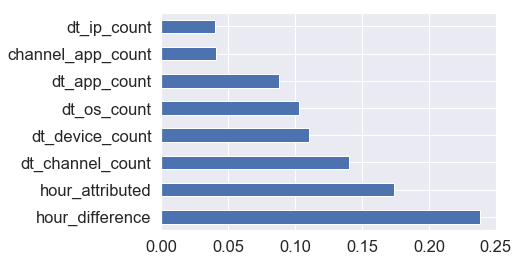

In [135]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=4,random_state=0, n_jobs=-1, class_weight="balanced")
clf.fit(X_train, y_train)  
feature_importances = pd.DataFrame(clf.feature_importances_,index = X_train.columns,columns=['importance']).sort_values('importance',ascending=False)
indices = np.argsort(feature_importances)[::-1]
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)

print(feature_importances)

feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(8).plot(kind='barh')

NameError: name 'X_test' is not defined